# 6. GO/STOP! - Object Detection 시스템 만들기

## 8. 프로젝트: 자율주행 보조 시스템 만들기

### 준비물
---
아직 경로를 생성하지 않았다면 터미널을 열고 개인 실습 환경에 따라 경로를 수정, 프로젝트를 위한 디렉토리를 생성하자.

```bash
$ mkdir -p ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/data
```

__(주의)__ [RetinaNet 홈페이지](https://github.com/fizyr/keras-retinanet)에 보면 __tensorflow 2.3.0, tf.keras 2.4.0__을 사용할 것을 권장하며, 그보다 높은 버전에서는 오류가 발생한다고 안내하고 있다. 만약 가상환경에 설치된 Tensorflow 버전이 2.3.0보다 높을 경우 2.3.0에 맞추어 재설치하거나,<br>
아니면 별도의 가상환경을 생성 후 해당 환경에서 jupyter notebook으로 실습을 진행할 것을 권한다.

```bash
$ pip uninstall tensorflow
$ pip install tensorflow==2.3.0
```

프로젝트 디렉토리로 이동한다. 그 후 다음 리포지토리(repository)를 받고, 리포지토리 사용에 필요한 케라스 라이브러리를 가상환경 내에 설치해준다.

```bash
$ cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection
$ git clone https://github.com/fizyr/keras-retinanet.git
$ cd keras-retinanet && python setup.py build_ext --inplace
```

필요사항을 설치하고, `keras-retinanet` 또한 pip 패키지로 인스톨해준다.

```bash
$ pip install tensorflow_datasets tqdm
$ pip install -r requirements.txt
$ pip install .
```

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


아래 코드를 통해서 KITTI 데이터셋을 다운로드하자.

>_(주의) 이 데이터셋은 11GB가 넘어가는 대용량 데이터셋이다. 다운로드 소요시간이 수시간 이상 지속될 수 있다._

In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 `tfds.show_examples`를 통해 보도록하자. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있다.

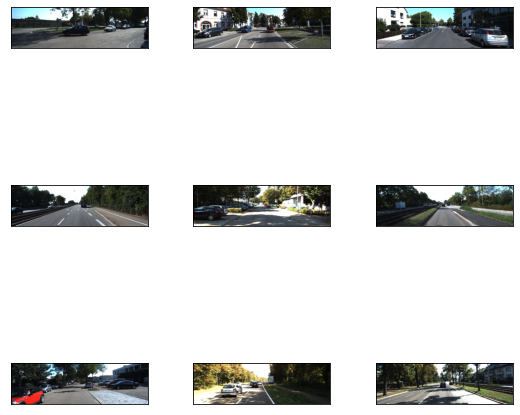

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 `ds_info`에서는 불러온 데이터셋의 정보를 확인할 수 있다. 오늘 사용할 데이터셋은 7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있다. 라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있다.

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj10/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

### 3.  데이터 직접 확인하기
---
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠다. `ds_train.take(1)`을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 `TakeDataset`을 얻을 수 있다. 이렇게 뽑은 데이터에는 `image` 등의 정보가 포함되어 있다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해보자.

In [6]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.52], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.44957334, 0.6630193 , 0.53458667, 0.73496777]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.62, 1.72, 4.35]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[13.89,  1.74, 39.1 ]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.18], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


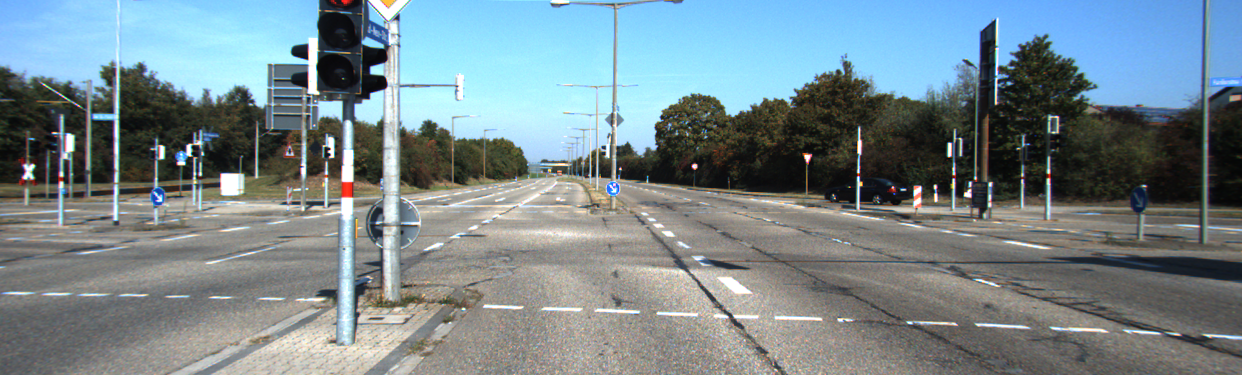

In [7]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

이미지와 라벨을 얻는 방법을 알게 되었다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, `bbox`)를 확인하기 위해서는 어떻게 해야 할까?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명이다.

```python
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```

힌트: [Pillow 라이브러리의 `ImageDraw` 모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)을 참고하자.

width: 1242  height: 375
(1, 4)
[823.47    206.41    912.82996 174.53   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FDB08169C50>


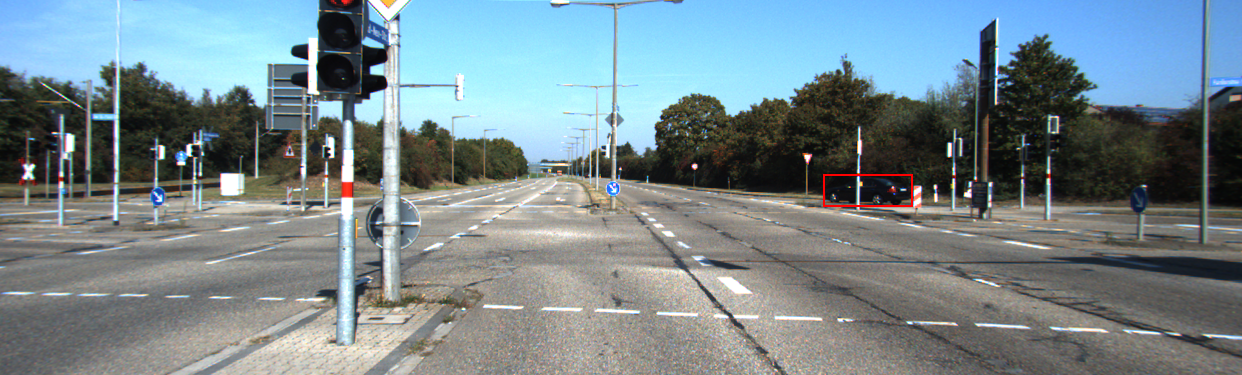

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 클래스 및 바운딩 박스 정보 추출
---
우리는 `tensorflow_dataset`의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었다. 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해보자.

한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성하자. 우리가 생각하는 브레이크 시스템은 차와 사람을 구분해야 하는 점을 유의해서 진행하자.

데이터셋 포맷은 아래를 참고해보자.

```python
# 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name

# Example
/data/imgs/img_001.jpg,837,346,981,456,cow
/data/imgs/img_002.jpg,215,312,279,391,cat
/data/imgs/img_002.jpg,22,5,89,84,bird
/data/imgs/img_003.jpg,,,,,
```

CSV로 저장할 때는 아래 코드를 참고하자.

```python
# 데이터셋 저장 시 참고
df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
df_test.to_csv('./kitti_test.csv', sep=',',index = False, header=False)
```

tqdm은 루프문의 상태에 따라 콘솔에 진행 상황 바를 표시할 수 있는 라이브러리이다. 자세한 사항은 리포지토리를 참고.

* [GitHub: tqdm](https://github.com/tqdm/tqdm)

In [9]:
import os
data_dir = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [13:54<00:00,  7.60it/s]


테스트 데이터셋에 대해서도 동일하게 `parse_dataset()` 을 적용해서 dataframe을 생성해보자.

In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:39<00:00,  7.15it/s]


### 클래스 맵핑
---
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야한다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있다.

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 보자.

```python
class_name,id

#Example
cow,0
cat,1
bird,2
```

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

### RetinaNet 훈련
---

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-27 17:40:14.355172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 17:40:16.828658: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 17:40:16.832545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 17:40:16.858702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 17:40:16.859134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 17:40:16.859156: I tensorflow/stream_executor/platform/default/d

2021-04-27 17:40:21.390558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-27 17:40:21.390924: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
2021-04-27 17:40:28.207678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-04-27 17:40:29.555068: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-04-27 17:40:29.614838: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-27 17:40:30.152896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-04-27 17:40:41.201358: W tensor

195/195 [==============================] - 63s 322ms/step - loss: 1.4619 - regression_loss: 1.1612 - classification_loss: 0.3007

Epoch 00013: saving model to ./snapshots/resnet50_csv_13.h5
Epoch 14/50
195/195 [==============================] - 63s 323ms/step - loss: 1.4090 - regression_loss: 1.0959 - classification_loss: 0.3131

Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 15/50
195/195 [==============================] - 63s 323ms/step - loss: 1.3678 - regression_loss: 1.0616 - classification_loss: 0.3063

Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
Epoch 16/50
195/195 [==============================] - 63s 320ms/step - loss: 1.1097 - regression_loss: 0.8570 - classification_loss: 0.2528

Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
Epoch 17/50
195/195 [==============================] - 63s 322ms/step - loss: 1.0818 - regression_loss: 0.8393 - classifica

195/195 [==============================] - 64s 324ms/step - loss: 1.1687 - regression_loss: 0.8979 - classification_loss: 0.2709

Epoch 00034: saving model to ./snapshots/resnet50_csv_34.h5
Epoch 35/50
195/195 [==============================] - 64s 324ms/step - loss: 1.1511 - regression_loss: 0.8698 - classification_loss: 0.2813

Epoch 00035: saving model to ./snapshots/resnet50_csv_35.h5

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.9999988758398e-14.
Epoch 36/50
195/195 [==============================] - 62s 317ms/step - loss: 1.1190 - regression_loss: 0.8563 - classification_loss: 0.2627

Epoch 00036: saving model to ./snapshots/resnet50_csv_36.h5
Epoch 37/50
195/195 [==============================] - 61s 310ms/step - loss: 1.0787 - regression_loss: 0.8253 - classification_loss: 0.2534

Epoch 00037: saving model to ./snapshots/resnet50_csv_37.h5

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.
Epoch 38/50
195/195 [=======================

아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환하자.

In [13]:
!cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 18:34:33.322143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 18:34:35.449843: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 18:34:35.453653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 18:34:35.477467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 18:34:35.477884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 18:34:35.477907: I tensorflow/stream_executor/platform/default/d

### 시각화
이제 위에서 변환한 모델을 load하고 추론 및 시각화를 해보자.

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성하자. 일정 점수 이하는 경우를 제거해야 함을 유의하자.

아래에서 몇 가지 테스트 셋을 받아 사용해보자.

```bash
$ mkdir -p ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
$ mv test_set.zip ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set
$ cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set && unzip test_set.zip
```

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

1 Physical GPUs, 1 Logical GPUs


[592.95337 175.23953 625.7326  205.25526]
[196.46698 135.46002 355.3052  226.98053]


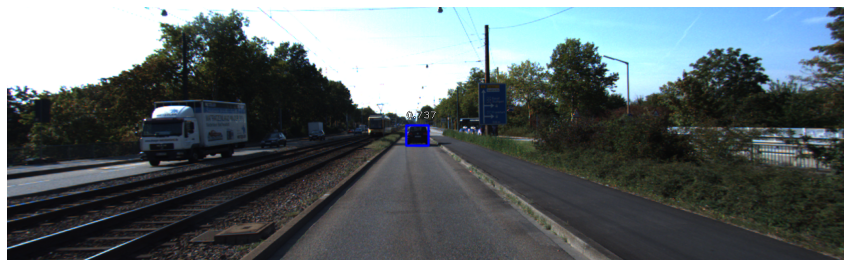

In [15]:
import os
img_path = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

### 1. 자율주행 시스템 만들기
---
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들자.

- 입력으로 이미지 경로를 받는다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환한다.
- 조건은 다음과 같다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우
    
```python
img_path = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))    
```

### 2. 자율주행 시스템 평가하기

---

아래 **`test_system()`** 를 통해서 위에서 만든 함수를 평가해보자. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해준다.

```python
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)
```

In [17]:
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5: break
        if label == 1: return 'Stop'# 사람이 한 명 이상 있는 경우
        elif label == 0: # 자동차가 있는 경우
            # 자동차 크기(너비 또는 높이)가 300px이상일 경우 Stop 반환
            if abs(box[0]-box[2]) >= 300 or abs(box[1]-box[3]) >= 300: return 'Stop'
    
    # 위 2개의 조건 모두 해당하지 않는다면 Go 반환
    return 'Go'

In [20]:
import os

def test_system(func):
    work_dir = os.getenv("HOME") + '/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist) # 100점입니다.

90점입니다.


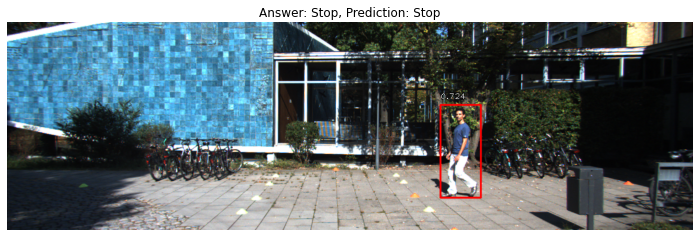

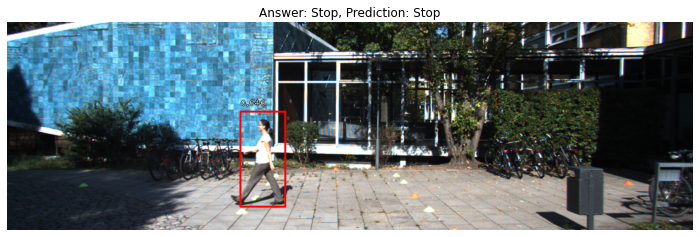

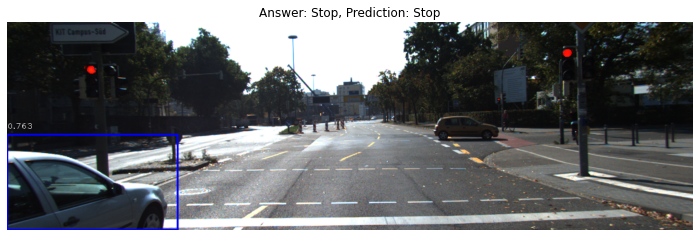

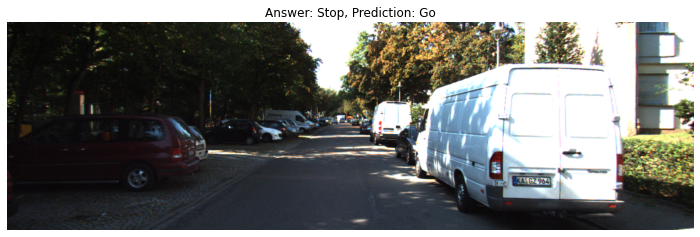

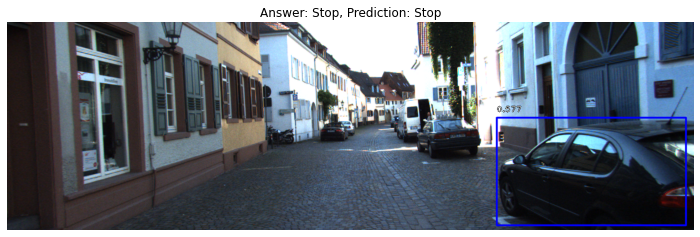

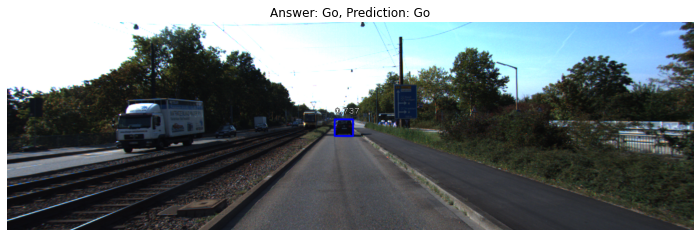

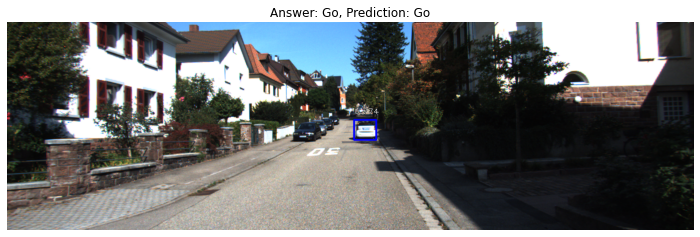

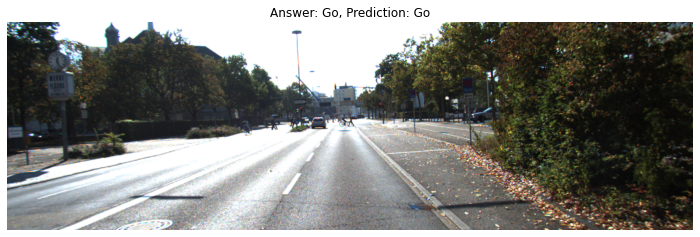

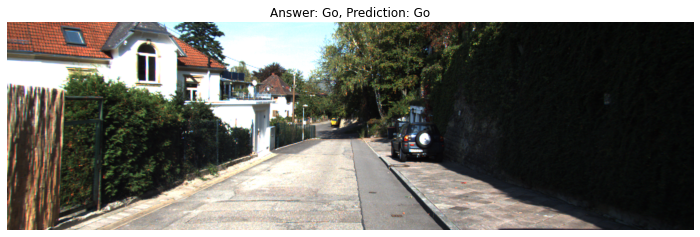

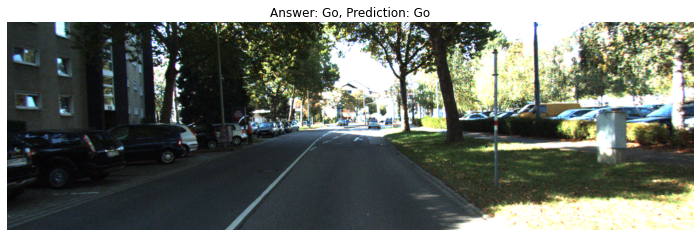

In [21]:
import os

work_dir = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/'

test_set=[
    ("test_set/stop_1.png", "Stop"),
    ("test_set/stop_2.png", "Stop"),
    ("test_set/stop_3.png", "Stop"),
    ("test_set/stop_4.png", "Stop"),
    ("test_set/stop_5.png", "Stop"),
    ("test_set/go_1.png", "Go"),
    ("test_set/go_2.png", "Go"),
    ("test_set/go_3.png", "Go"),
    ("test_set/go_4.png", "Go"),
    ("test_set/go_5.png", "Go"),
]

for index, (img_path, answer) in enumerate(test_set):
    
    image = read_image_bgr(work_dir+img_path)
    pred = self_drive_assist(work_dir+img_path) # Go 또는 Stop
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    # correct for image scale
    boxes /= scale
    
    # display images
    for box, score, label in zip(boxes[0], scores[0], labels[0]):   
        if score < 0.5:
            break
        
        b = box.astype(int)
        draw_box(draw, b, color=color_map[label])

        caption = "{:.3f}".format(score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(45, 45))
    plt.subplot(len(test_set),1,index+1)
    plt.axis('off')
    plt.imshow(draw)
    plt.title('Answer: {}, Prediction: {}'.format(answer, pred))
    plt.show()

### 회고
---
* 이론만 보던 ResNet을 직접 구현해보니, Residual Block이 더 와닿았다.
* 처음 직접 쌓아본 모델이었는데, 처음부터 끝까지 다할 수 있었다면 좋았겠지만, 구글링을 통해 baseline을 얻었다.
* 긴 시간동안 사투하면서 힘들었지만, 그래도 흥미를 느꼈다.

### 루브릭
---
* KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.<br>
(_KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다._)

    * __모델의 summary가 적절하게 출력되었다..__

* RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.<br>
( _바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다._)
    
    * __모델학습을 진행하였고, loss값과 val_loss값의 감소 진행이 확인되었다.__

* 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.<br>
(_테스트 수행결과 90% 이상의 정확도를 보였다._)
    
    * __residual 모델과 plain 모델의 accuracy를 비교해서 ablation study를 진행하였다.__